In [1]:
base_path = "./data"
year = "2020"
fire_id = "24332939"

interesting_data = [
    "fire_24332939",  # this one has a lot of fires
    "fire_24332949",
    "fire_24332798"
]

folder = base_path + f"/{year}/fire_{fire_id}"

# file_path = folder + f"/2018-08-15.tif"

In [2]:
import pprint
import rasterio
from rasterio import features
import rasterio.warp
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

In [3]:
# Base values
channel_descriptions = ['M11', 'I2', 'I1', 'NDVI_last', 'EVI2_last', 'total precipitation', 'wind speed', 'wind direction', 'minimum temperature', 'maximum temperature', 'energy release component', 'specific humidity', 'slope', 'aspect', 'elevation', 'pdsi', 'LC_Type1', 'total_precipitation_surface_last', 'forecast wind speed', 'forecast wind direction', 'forecast temperature', 'forecast specific humidity', 'active fire']

min_values = [np.float32(-100.0),
 np.float32(-100.0),
 np.float32(-100.0),
 np.float32(-9966.0),
 np.float32(-4519.0),
 np.float32(0.0),
 np.float32(0.4),
 np.float32(0.0),
 np.float32(242.0),
 np.float32(257.5),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(-0.0),
 np.float32(-84.0),
 np.float32(-6.72),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(-89.999214),
 np.float32(-13.984883),
 np.float32(0.0),
 np.float32(0.0)]

max_values = [np.float32(15985.0),
 np.float32(15985.0),
 np.float32(15997.0),
 np.float32(9993.0),
 np.float32(9997.0),
 np.float32(122.0),
 np.float32(16.2),
 np.float32(360.0),
 np.float32(311.8),
 np.float32(325.4),
 np.float32(122.0),
 np.float32(0.01888),
 np.float32(67.07325),
 np.float32(359.89072),
 np.float32(4344.0),
 np.float32(8.28),
 np.float32(17.0),
 np.float32(204.1875),
 np.float32(14.295916),
 np.float32(89.98897),
 np.float32(39.505894),
 np.float32(0.014013266),
 np.float32(2218.0)]

min_values = [np.float32(-100.0),
  np.float32(-100.0),
  np.float32(-100.0),
  np.float32(-9863.268),
  np.float32(-4422.217),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(-84.0),
  np.float32(-6.72),
  np.float32(1.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(-89.999214),
  np.float32(-13.984883),
  np.float32(0.0),
  np.float32(0.0)]

max_values = [np.float32(15976.0),
  np.float32(15799.0),
  np.float32(15744.0),
  np.float32(9975.073),
  np.float32(9856.787),
  np.float32(122.0),
  np.float32(16.2),
  np.float32(360.0),
  np.float32(311.8),
  np.float32(325.4),
  np.float32(122.0),
  np.float32(0.01888),
  np.float32(63.85685),
  np.float32(359.42383),
  np.float32(4268.336),
  np.float32(8.28),
  np.float32(17.0),
  np.float32(204.1875),
  np.float32(14.295916),
  np.float32(89.98897),
  np.float32(39.505894),
  np.float32(0.0122514665),
  np.float32(2218.0)]

In [4]:
fire_folders = []
look_back = 5   # 5 days sequence
all_frames = []
data_limit, loop_counter, loop_start = 5, 0, 0
channel_descriptions = None

target_shape_x, target_shape_y = 128, 128

print('Loading...')

for fire_folder in os.listdir(base_path):
    loop_counter += 1
    if loop_counter - loop_start >= data_limit:
        break
    if loop_counter < loop_start:
        continue
    print('Progress: {0}/{1} ({2})'.format(loop_counter - loop_start + 1, data_limit, loop_counter))
    fire_folders.append(fire_folder)
    for image_name in os.listdir(base_path + f"/{fire_folder}"):
        file_path = base_path + f"/{fire_folder}/{image_name}"
        
        with rasterio.open(file_path, 'r') as geotiff:
            src = geotiff.read()
            channel_descriptions = geotiff.descriptions
            zoom_factor = (1, target_shape_x / src.shape[1], target_shape_y / src.shape[2])
            resized_src = zoom(src, zoom_factor, order=1)
            resized_src = np.nan_to_num(resized_src, copy=False)
            all_frames.append(resized_src)
            
            if fire_folder == 'fire_24332939' and False:
                print(f"shape: {geotiff.shape}")
                last_index = len(geotiff.indexes) - 1
                last_image = geotiff.read(geotiff.indexes[last_index])
                plt.figure()
                plt.title(geotiff.descriptions[last_index])
                plt.imshow(last_image)

print(f'Loading done! Count = {len(all_frames)} | Shape = {all_frames[0].shape}')

data_frames = np.stack(all_frames)
print(data_frames.shape)

Loading...
Progress: 2/5 (1)
Progress: 3/5 (2)
Progress: 4/5 (3)
Progress: 5/5 (4)
Loading done! Count = 114 | Shape = (23, 128, 128)
(114, 23, 128, 128)


41.527557 11357.947
41.527557 11357.947


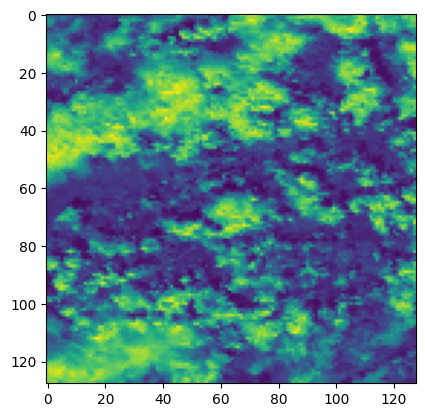

In [5]:
plt.figure()
sample_frame = data_frames[21, 1]
plt.imshow(sample_frame)

print(np.nanmin(sample_frame), np.nanmax(sample_frame))
print(np.min(sample_frame), np.max(sample_frame))

In [6]:
from sklearn.preprocessing import MinMaxScaler, minmax_scale

for c in range(23):
    data_frames[:, c, :, :] = (data_frames[:, c, :, :] - min_values[c]) / (max_values[c] - min_values[c])

In [7]:
np.min(data_frames), np.max(data_frames)

(np.float32(0.0), np.float32(1.0))

In [8]:
X = []
Y = []

for t in range(0, data_frames.shape[0] - look_back):
    x_seq = data_frames[t:t+look_back]               # shape: (5, 23, H, W)
    y_mask = data_frames[t + look_back, 22]           # fire mask from channel 22

    X.append(x_seq)
    Y.append(y_mask)     # binarize

X = np.stack(X)  # shape: (273, 5, 23, 330, 257)
Y = np.stack(Y)  # shape: (273, 330, 257)

print(X.shape)
print(Y.shape)

(109, 5, 23, 128, 128)
(109, 128, 128)


In [9]:
split_index = int(X.shape[0] * 0.9)

X_train = X[:split_index]
X_val = X[split_index:]

Y_train = Y[:split_index]
Y_val = Y[split_index:]

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((98, 5, 23, 128, 128), (98, 128, 128), (11, 5, 23, 128, 128), (11, 128, 128))

In [10]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float().unsqueeze(1)

X_val = torch.tensor(X_val).float()
Y_val = torch.tensor(Y_val).float().unsqueeze(1)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([98, 5, 23, 128, 128]),
 torch.Size([98, 1, 128, 128]),
 torch.Size([11, 5, 23, 128, 128]),
 torch.Size([11, 1, 128, 128]))

In [11]:
class WildfireDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

train_dataset = WildfireDataset(X_train, Y_train)
val_dataset = WildfireDataset(X_val, Y_val)


In [12]:
len(train_dataset), len(val_dataset)

(98, 11)

In [13]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
import convlstm

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.clstm = convlstm.ConvLSTM(
            input_size=(128, 128),
            input_dim=23,
            hidden_dim=[64],
            kernel_size=(3, 3),
            num_layers=1
        )
        # (8, 64, 330, 257)
        
        self.head = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        # (8, 1, 330, 257)

    def forward(self, x):
        batch_size = x.size(0)
        outputs, last_states = self.clstm(x)

        x = outputs[0][:, -1, :, :, :]
        x = self.head(x)
        return x

model = Net().to(device)

In [16]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        self.bce = nn.BCELoss()

    def forward(self, y_pred, y_true):
        #bce_loss = self.bce(y_pred, y_true)

        y_pred_flat = y_pred.view(y_pred.size(0), -1)
        y_true_flat = y_true.view(y_true.size(0), -1)

        intersection = (y_pred_flat * y_true_flat).sum(dim=1)
        union = y_pred_flat.sum(dim=1) + y_true_flat.sum(dim=1)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score.mean()

        return dice_loss


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = 0.001 # 0.0001
num_epochs = 25
#num_epochs = 100

loss_fn = DiceLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print_batch_every = 4

def train(epoch):
    model.train(True)
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % print_batch_every == (print_batch_every - 1):
            avg_loss_across_batches = running_loss / print_batch_every
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0
    print()

def validate():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(val_loader)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('**********************************************************')
    print()

for epoch in range(num_epochs):
    train(epoch)
    validate()


Epoch: 1


C:\Users\neelr\AppData\Local\Temp\ipykernel_37600\1262478855.py:22: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  running_loss += loss.item()


Batch 4, Loss: 0.999
Batch 8, Loss: 0.999
Batch 12, Loss: 0.996

Val Loss: 0.995
**********************************************************

Epoch: 2
Batch 4, Loss: 0.995
Batch 8, Loss: 0.993
Batch 12, Loss: 0.991

Val Loss: 0.989
**********************************************************

Epoch: 3
Batch 4, Loss: 0.988
Batch 8, Loss: 0.984
Batch 12, Loss: 0.979

Val Loss: 0.972
**********************************************************

Epoch: 4
Batch 4, Loss: 0.966
Batch 8, Loss: 0.956
Batch 12, Loss: 0.948

Val Loss: 0.923
**********************************************************

Epoch: 5
Batch 4, Loss: 0.905
Batch 8, Loss: 0.881
Batch 12, Loss: 0.874

Val Loss: 0.812
**********************************************************

Epoch: 6
Batch 4, Loss: 0.771
Batch 8, Loss: 0.738
Batch 12, Loss: 0.751

Val Loss: 0.658
**********************************************************

Epoch: 7
Batch 4, Loss: 0.599
Batch 8, Loss: 0.595
Batch 12, Loss: 0.650

Val Loss: 0.554
*******************

In [18]:
for batch_index, batch in enumerate(val_loader):
    if batch_index == 0:
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        y_pred = model(x_batch)
        break

In [19]:
torch.max(y_batch), torch.max(y_pred), torch.min(y_batch), torch.min(y_pred)

(tensor(0.9919, device='cuda:0'),
 tensor(4.6447e-07, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0'),
 tensor(4.4439e-07, device='cuda:0', grad_fn=<MinBackward1>))

In [20]:
y_batch_np = y_batch.cpu().detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()

In [21]:
y_batch_np.shape, y_pred_np.shape

((8, 1, 128, 128), (8, 1, 128, 128))

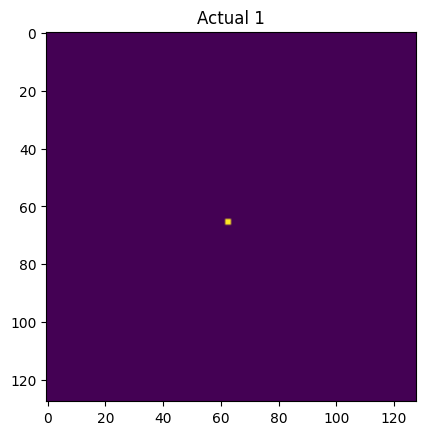

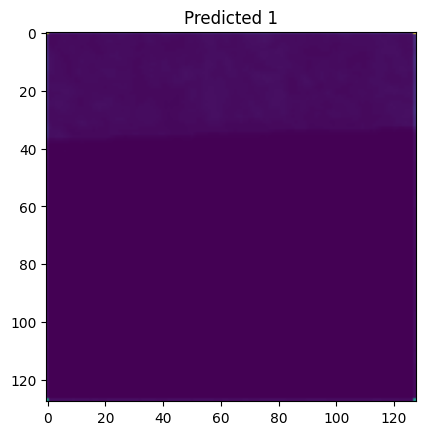

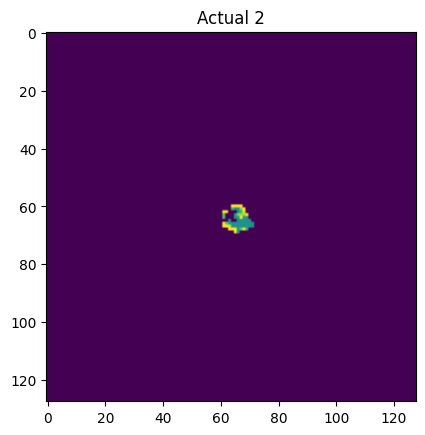

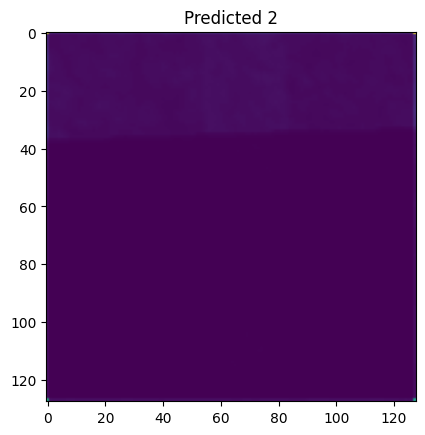

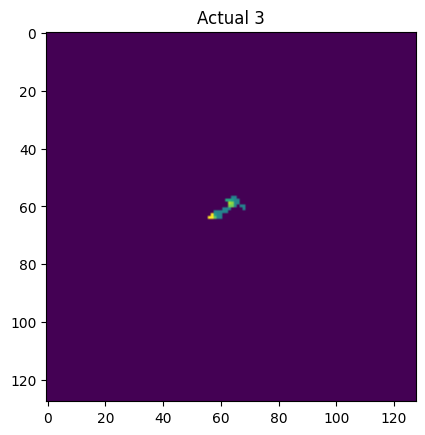

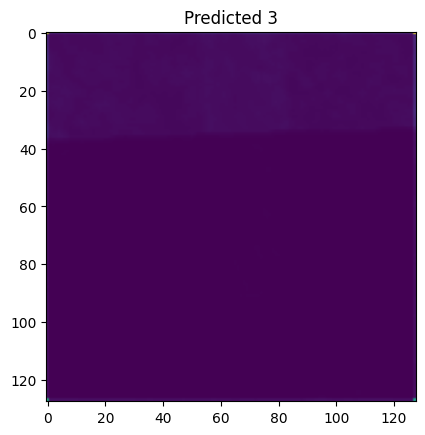

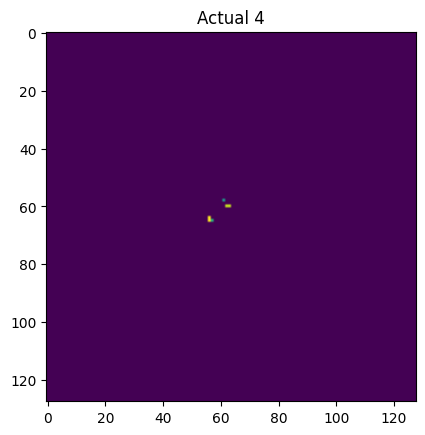

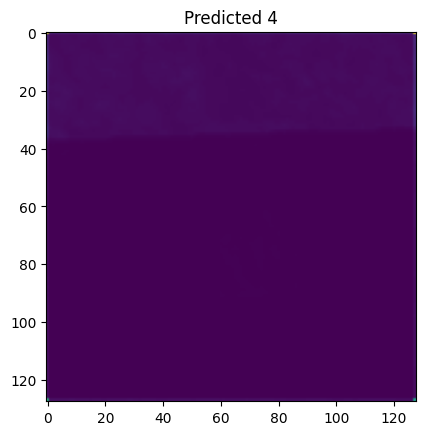

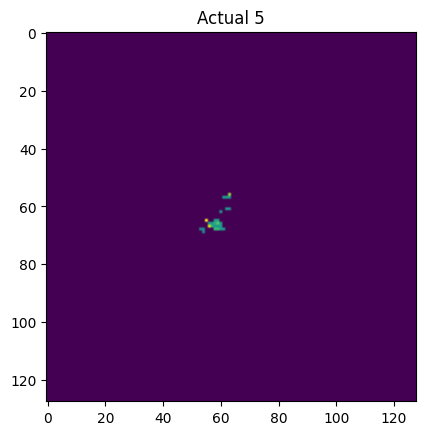

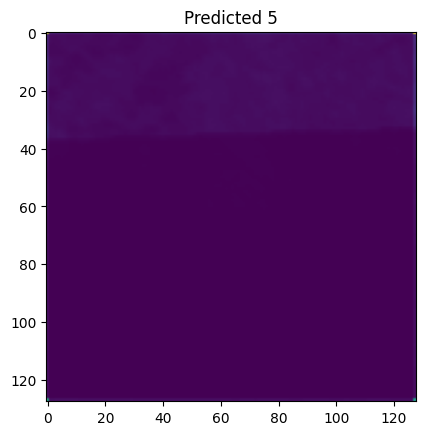

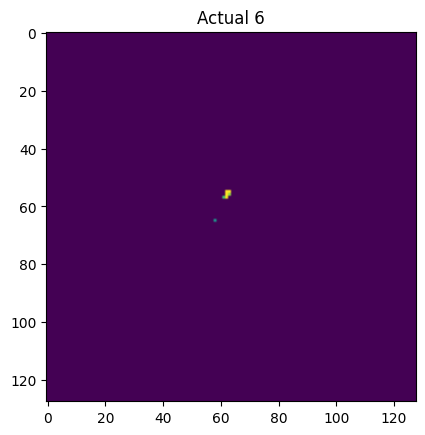

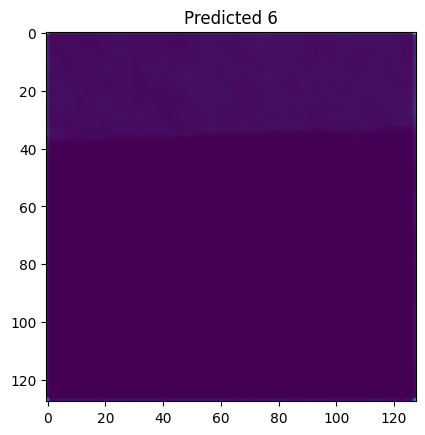

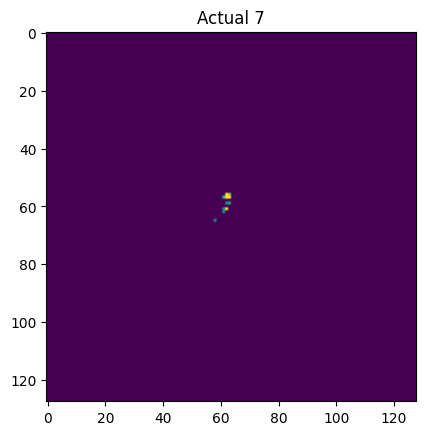

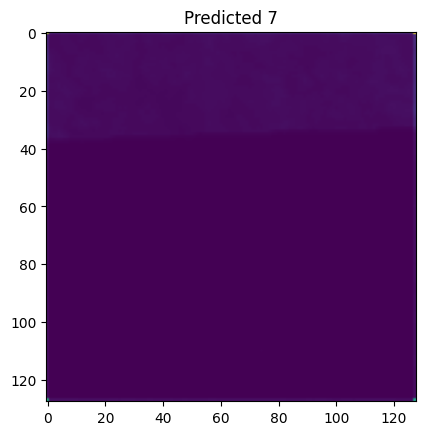

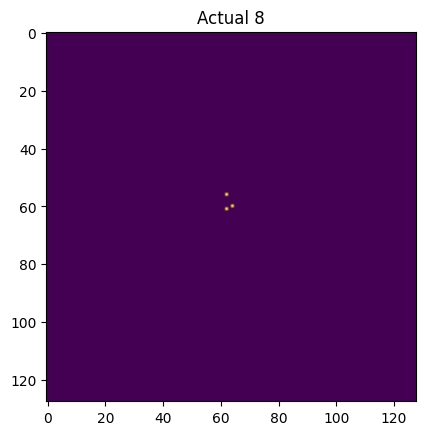

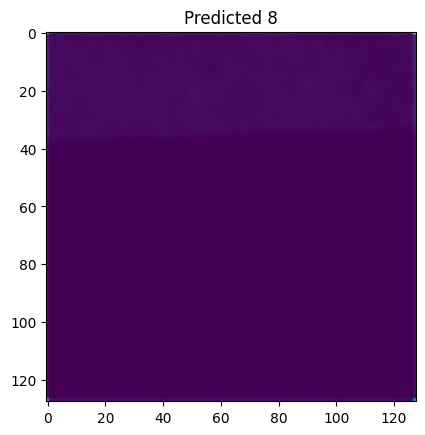

In [22]:
for i in range(y_batch_np.shape[0]):
    plt.figure()
    plt.title(f"Actual {i + 1}")
    plt.imshow(y_batch_np[i, 0])

    plt.figure()
    plt.title(f"Predicted {i + 1}")
    plt.imshow(y_pred_np[i, 0])